In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast
from matplotlib.ticker import FuncFormatter

In [2]:
types = ["sinks", "sources", "workers"]
hatches = {
    "nemo": "//",
    "bottom_up": "--",
    "top_down": "x"
}

def format_func(value, tick_number):
    k_value = int(value) // 1000
    if k_value == 0:
        return f"{value:.0f}"
    elif k_value == 1:
        return f"{k_value}k"
    else:
        return f"{k_value:,}k"

def plot_bar_for_type(ax, df, type, val_col, ylabel, title=True, show_text=True):
    df = df.groupby(['approach', 'type', 'node_id'])[val_col].max().reset_index()
    df = df.groupby(['approach', 'type'])[val_col].mean().reset_index()
    df = df[df['type'] == type]
    for app in df["approach"].tolist():
        val = df[df['approach'] == app][val_col].tolist()[0]  # Extract the single value
        ax.bar(app, val, color="black", hatch=hatches[app])
        if show_text:
            ax.text(app, val, f"{val:.0f}", ha='center', va='bottom', fontsize=16)

    if show_text:
        # Calculate the maximum y-axis value
        max_y = ax.get_ylim()[1]
        # Set y-axis limit slightly higher to make space for labels
        ax.set_ylim(0, max_y * 1.4)
    
    # set title
    if type == "workers":
        type = "cluster heads"
    if title:
        ax.set_title(type)
    ax.set_ylabel(ylabel)

    # Apply the formatting function to the y-axis using FuncFormatter
    formatter = FuncFormatter(format_func)
    ax.yaxis.set_major_formatter(formatter)
    return ax


def convert_bytes_to_megabytes(df, columns):
    for col in columns:
        df[col] = df[col] / (1024 ** 2)  # convert from bytes to megabytes
    return df


def get_type(node_id):
    type = "invalid"
    node_id = int(node_id)
    if node_id in coordinator:
        type = "sinks"
    elif node_id in workers:
        type = "workers"
    elif node_id in sensors:
        type = "sources"
    return type

In [3]:
approaches = ["topdown", "bottomup", "nemo"]
metrics = ["cpu", "net"]
samples = ["100"]
stress_label = "no_stress"
labels = {
    "nemo": "nemo",
    "bottomup": "bottom_up",
    "topdown": "top_down"
}
root_dir = "datasets/NES/210723/window_1_100/metrics/"
core_cols = ["time (s)", "node_id", "approach", "type"]
columns = {
    "cpu": ["cpu_user", "cpu_nice", "cpu_system"],
    "net": ["R_BYTES", "R_PACKETS", "T_BYTES", "T_PACKETS"]
}
coordinator = [1]
sensors = [3, 4, 5, 6, 8, 9, 10, 11]
workers = [2, 7]

df_dict = {}
for metric in metrics:
    rows = []
    for sample in samples:
        for app in approaches:
            fname = root_dir + app + "_" + stress_label + "_" + sample + "_" + metric + ".txt"
            file = open(fname, 'r')
            lines = file.readlines()
            print("Reading lines for", fname)
            for line in lines:
                sline = line.split(",", 1)
                timestamp = sline[0]
                dictionary_str = sline[1]
                dictionary = ast.literal_eval(dictionary_str)
                for node_id, metrics_dict in dictionary.items():
                    type = get_type(node_id)
                    if metric == "cpu":
                        row = [float(timestamp), node_id, labels[app], type, float(metrics_dict["cpu_user"]), float(metrics_dict["cpu_nice"]),
                               float(metrics_dict["cpu_system"])]
                    elif metric == "net":
                        row = [float(timestamp), node_id, labels[app], type, float(metrics_dict["R_BYTES"]), float(metrics_dict["R_PACKETS"]),
                               float(metrics_dict["T_BYTES"]), float(metrics_dict["T_PACKETS"])]
                    else:
                        raise Exception("Unknown metric " + metric)
                    rows.append(row)
    df = pd.DataFrame(rows, columns = core_cols+columns[metric])
    # important pre-processing to remove the min values
    for col in columns[metric]:
        df[col] = df.groupby(['node_id', 'approach'])[col].transform(lambda x: x - x.min())
    df_dict[metric] = df

Reading lines for datasets/NES/210723/window_1_100/metrics/topdown_no_stress_100_cpu.txt
Reading lines for datasets/NES/210723/window_1_100/metrics/bottomup_no_stress_100_cpu.txt
Reading lines for datasets/NES/210723/window_1_100/metrics/nemo_no_stress_100_cpu.txt
Reading lines for datasets/NES/210723/window_1_100/metrics/topdown_no_stress_100_net.txt
Reading lines for datasets/NES/210723/window_1_100/metrics/bottomup_no_stress_100_net.txt
Reading lines for datasets/NES/210723/window_1_100/metrics/nemo_no_stress_100_net.txt


In [4]:
df_dict["cpu"]

,time (s),node_id,approach,type,cpu_user,cpu_nice,cpu_system
0,1.689855e+09,1,top_down,sinks,0.0,0.0,0.0
1,1.689855e+09,2,top_down,workers,0.0,0.0,0.0
2,1.689855e+09,3,top_down,sources,0.0,0.0,0.0
3,1.689855e+09,4,top_down,sources,0.0,0.0,0.0
4,1.689855e+09,5,top_down,sources,0.0,0.0,0.0
...,...,...,...,...,...,...,...
7420,1.689849e+09,7,nemo,workers,41351.0,0.0,1511.0
7421,1.689849e+09,8,nemo,sources,7521.0,0.0,819.0
7422,1.689849e+09,9,nemo,sources,9300.0,2588.0,2268.0
7423,1.689849e+09,10,nemo,sources,7717.0,0.0,1004.0


## CPU Utilization

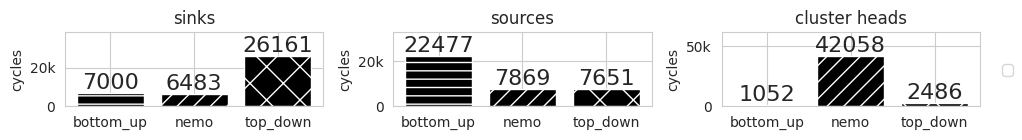

In [5]:
# Create and store the svg files
plot_col = "cpu_user"
for i, type in enumerate(types):
    # Create a new figure for each subplot
    fig, ax = plt.subplots(figsize=(8, 2))
    ax = plot_bar_for_type(ax, df_dict["cpu"], type, plot_col, "cycles", title=False)

    #ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='x', labelsize=20)

    fig.tight_layout()
    filename = os.path.join("plots/NES/", f"{type + '_' + plot_col}.svg")
    fig.savefig(filename)

    # Close the figure to free up memory
    plt.close(fig)

# Create the plot
fig, axs = plt.subplots(nrows=1, ncols=len(approaches), figsize=(10, 1.5))
for i, type in enumerate(types):
    axs[i] = plot_bar_for_type(axs[i], df_dict["cpu"], type, "cpu_user", "cycles")

# Create the legend outside the loop
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

# Show the plot
plt.show()

## Network

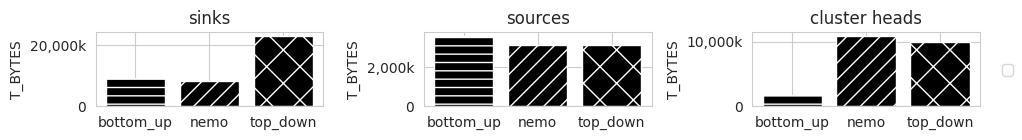

In [6]:
# Create and store the svg files
plot_col = "T_BYTES"
for i, type in enumerate(types):
    # Create a new figure for each subplot
    fig, ax = plt.subplots(figsize=(8, 2))
    ax = plot_bar_for_type(ax, df_dict["net"], type, plot_col, plot_col, title=False, show_text=False)

    #ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='x', labelsize=20)

    fig.tight_layout()
    filename = os.path.join("plots/NES/", f"{type + '_' + plot_col}.svg")
    fig.savefig(filename)

    # Close the figure to free up memory
    plt.close(fig)

# Create the plot
fig, axs = plt.subplots(nrows=1, ncols=len(approaches), figsize=(10, 1.5))
for i, type in enumerate(types):
    axs[i] = plot_bar_for_type(axs[i], df_dict["net"], type, "T_BYTES", "T_BYTES", show_text=False)

# Create the legend outside the loop
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

# Show the plot
plt.show()

## Produced Buffers

In [7]:
def rename(k):
    if k == "bottomup":
        k = "bottom_up"
    elif k == "topdown":
        k = "top_down"
    else:
        k = "nemo"
    return k

In [8]:
approaches = ["bottomup", "nemo", "topdown"]
prefix = "num_buffers"
buf_dict = {}
for app in approaches:
    fname = prefix + "_" + app + "_no_stress_100" + ".txt"
    df = pd.read_csv(root_dir + fname, names=["timestamp", "buffers"])
    buf_dict[app] = df

buf_dict.keys()

dict_keys(['bottomup', 'nemo', 'topdown'])

In [9]:
buf_dict["bottomup"]

,timestamp,buffers
0,1.689849e+09,0
1,1.689849e+09,0
2,1.689849e+09,0
3,1.689849e+09,0
4,1.689849e+09,0
...,...,...
236,1.689850e+09,2768
237,1.689850e+09,2784
238,1.689850e+09,2800
239,1.689850e+09,0


nemo 702
bottom_up 2800
top_down 25791


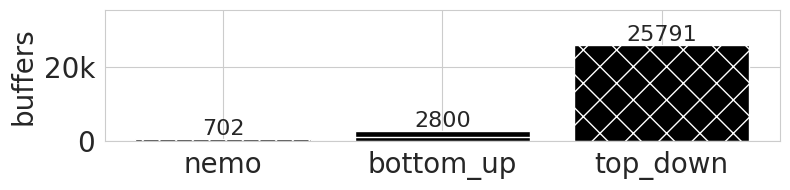

In [10]:
fig, ax = plt.subplots(figsize=(8, 2))
key_order = ["nemo", "bottomup", "topdown"]
    
for k in key_order:
    df = buf_dict[k]
    k = rename(k)
    val = df["buffers"].max()
    print(k, val)
    ax.bar(k, val, hatch=hatches[k], color="black")
    ax.text(k, val, f"{val:.0f}", ha='center', va='bottom', fontsize=16)

# Calculate the maximum y-axis value
max_y = ax.get_ylim()[1]
# Set y-axis limit slightly higher to make space for labels
ax.set_ylim(0, max_y * 1.3)

plt.ylabel("buffers", fontsize=20)
plt.tick_params(axis='both', labelsize=20)

formatter = FuncFormatter(format_func)
ax.yaxis.set_major_formatter(formatter)

fig.tight_layout()

plt.savefig("plots/NES/buffers" + ".svg")
plt.show()